## A guide to calculating APE in triply-periodic domains

Load necessary packages

In [1]:
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
%matplotlib inline
import numpy as np
import h5py
import pyfftw
import matplotlib.pyplot as plt
import cmocean

plt.style.use("thesis")

Read in the buoyancy perturbation field $\theta(x,z)$

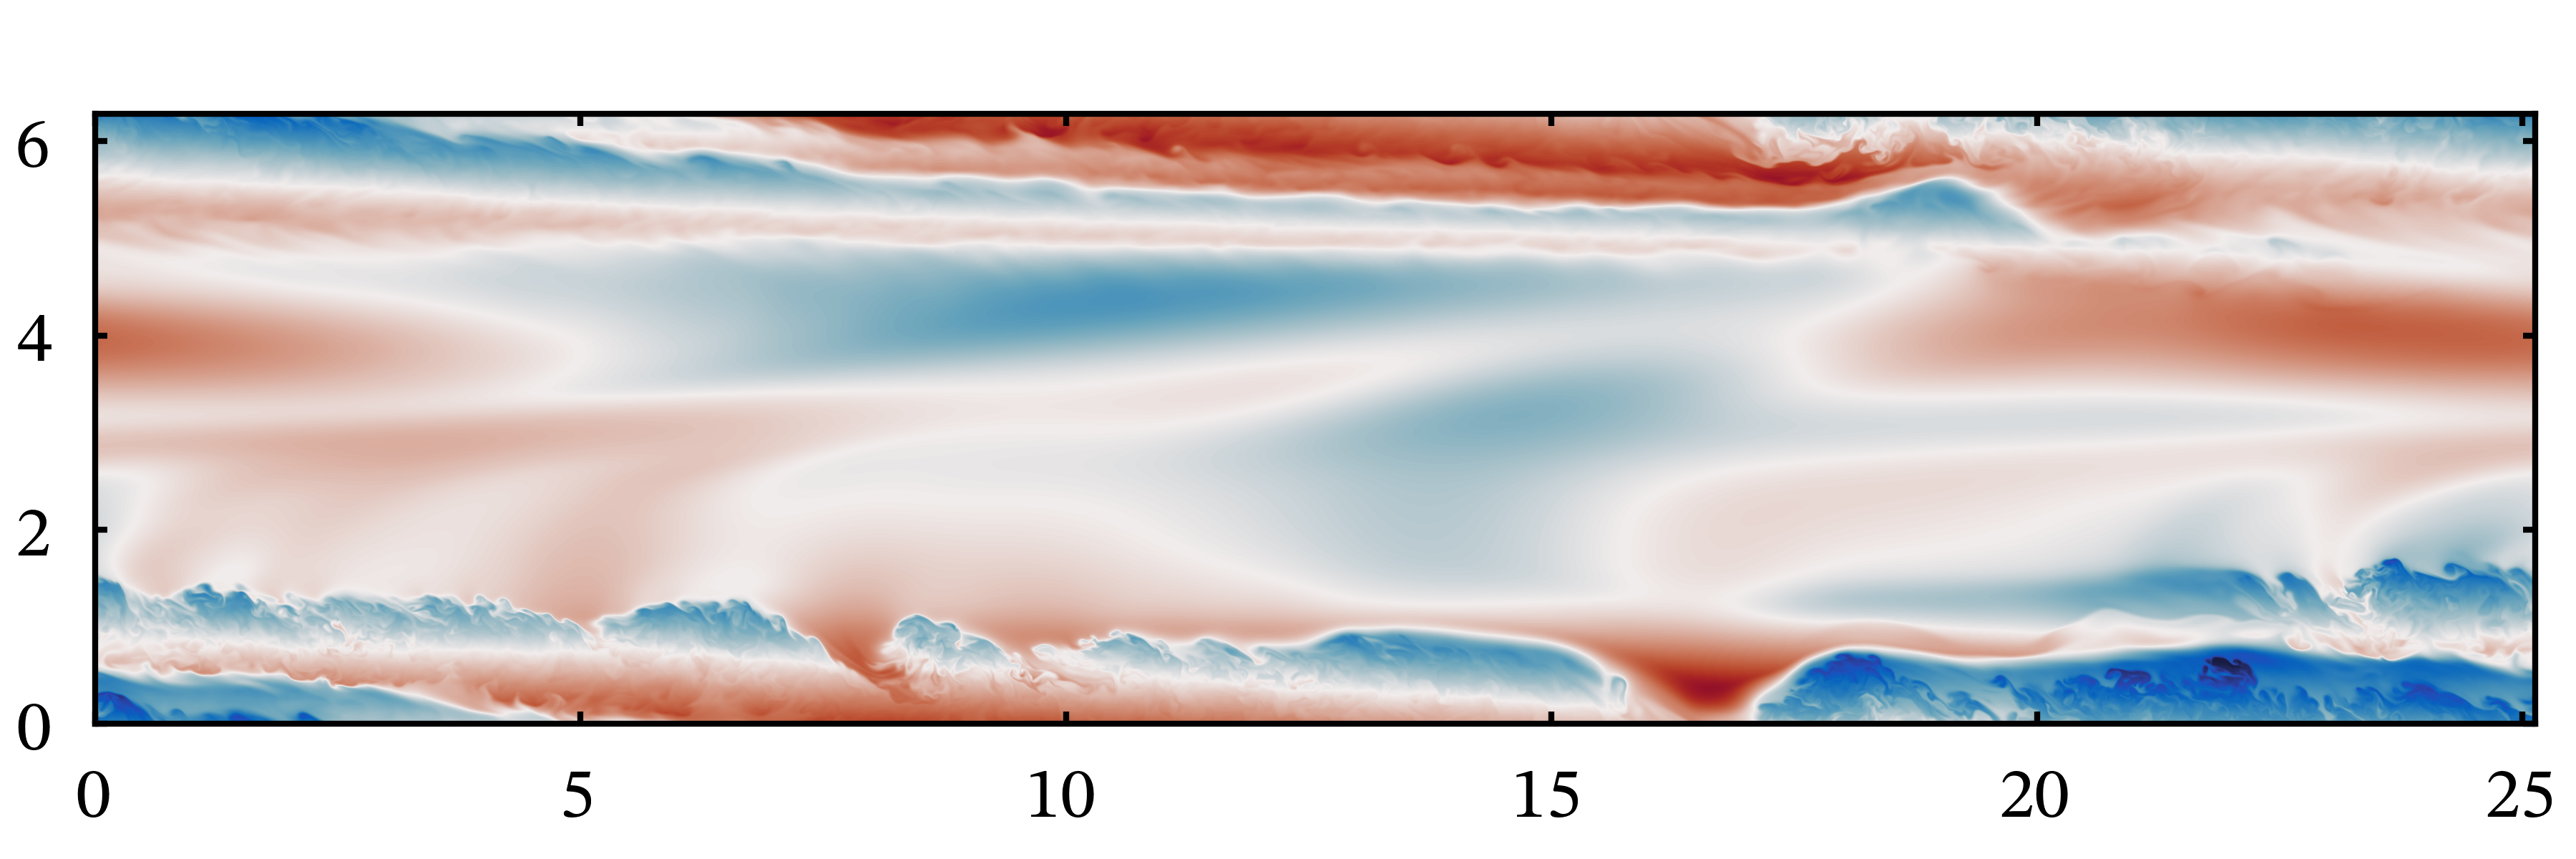

In [2]:
fname="gkb_stats/U1/APE.h5"
with h5py.File(fname,"r") as f:
    nz, nx = f["TH/12"].shape
    TH = f["TH/12"][()].T

# Define coordinate vectors:
xx = 2*np.pi*np.arange(nx)/nz
zz = 2*np.pi*np.arange(nz)/nz

fig, ax = plt.subplots(figsize=(6.0,2.0))
ax.imshow(
    TH.T, cmap='cmo.balance', vmin=-1, vmax=1, origin='lower',
    extent=[0, 8*np.pi, 0, 2*np.pi], aspect='equal'
)
ax.grid(False)
plt.show()

Create imaginary wavenumber vectors

In [3]:
CIKX = np.reshape(1j*np.arange(nx//2 + 1), (nx//2+1, 1))*nz/nx
CIKZ = 1j*np.arange(nz//2 + 1)

Define derivative operations for 2D arrays

In [4]:
# x-derivative (horizontal)
Ax=pyfftw.empty_aligned((nx,nz),dtype='float64')
Bx=pyfftw.empty_aligned((nx//2+1,nz),dtype='complex128')
ftx=pyfftw.FFTW(Ax, Bx, axes=(0,), direction='FFTW_FORWARD',threads=8)
iftx=pyfftw.FFTW(Bx, Ax, axes=(0,), direction='FFTW_BACKWARD',threads=8)
def ddx(S1):
    Ax[:,:] = S1
    ftx()
    Bx[:,:] = CIKX*Bx
    iftx()
    return Ax.copy()

# z-derivative (vertical)
Az=pyfftw.empty_aligned((nx,nz),dtype='float64')
Bz=pyfftw.empty_aligned((nx,nz//2+1),dtype='complex128')
ftz=pyfftw.FFTW(Az, Bz, axes=(1,), direction='FFTW_FORWARD',threads=8)
iftz=pyfftw.FFTW(Bz, Az, axes=(1,), direction='FFTW_BACKWARD',threads=8)
def ddz(S1):
    Az[:,:] = S1
    ftz()
    Bz[:,:] = CIKZ*Bz
    iftz()
    return Az.copy()

Define vertical derivative operation for 1D array

In [5]:
# 1D vertical derivative
As=pyfftw.empty_aligned(nz,dtype='float64')
Bs=pyfftw.empty_aligned(nz//2+1,dtype='complex128')
fts=pyfftw.FFTW(As, Bs, direction='FFTW_FORWARD')
ifts=pyfftw.FFTW(Bs, As, direction='FFTW_BACKWARD')
def dds(S1):
    As[:] = S1
    fts()
    Bs[:] = CIKZ*Bs
    ifts()
    return As.copy()

Preallocate variables

In [6]:
z0, dBdy, tmpFd = np.zeros(nx), np.zeros(nx), np.zeros(nx)
EP, EB, ES, EA = 0, 0, 0, 0
Ea, Eb = 0, 0
b_mean, z1_mean = 0, 0
Kd, M, Fd = 0, 0, 0

In [7]:
# Prescribe the Reynolds number
Re = 8000
# Diffusive term
Dp = 1/Re

### Calculate boundary contour

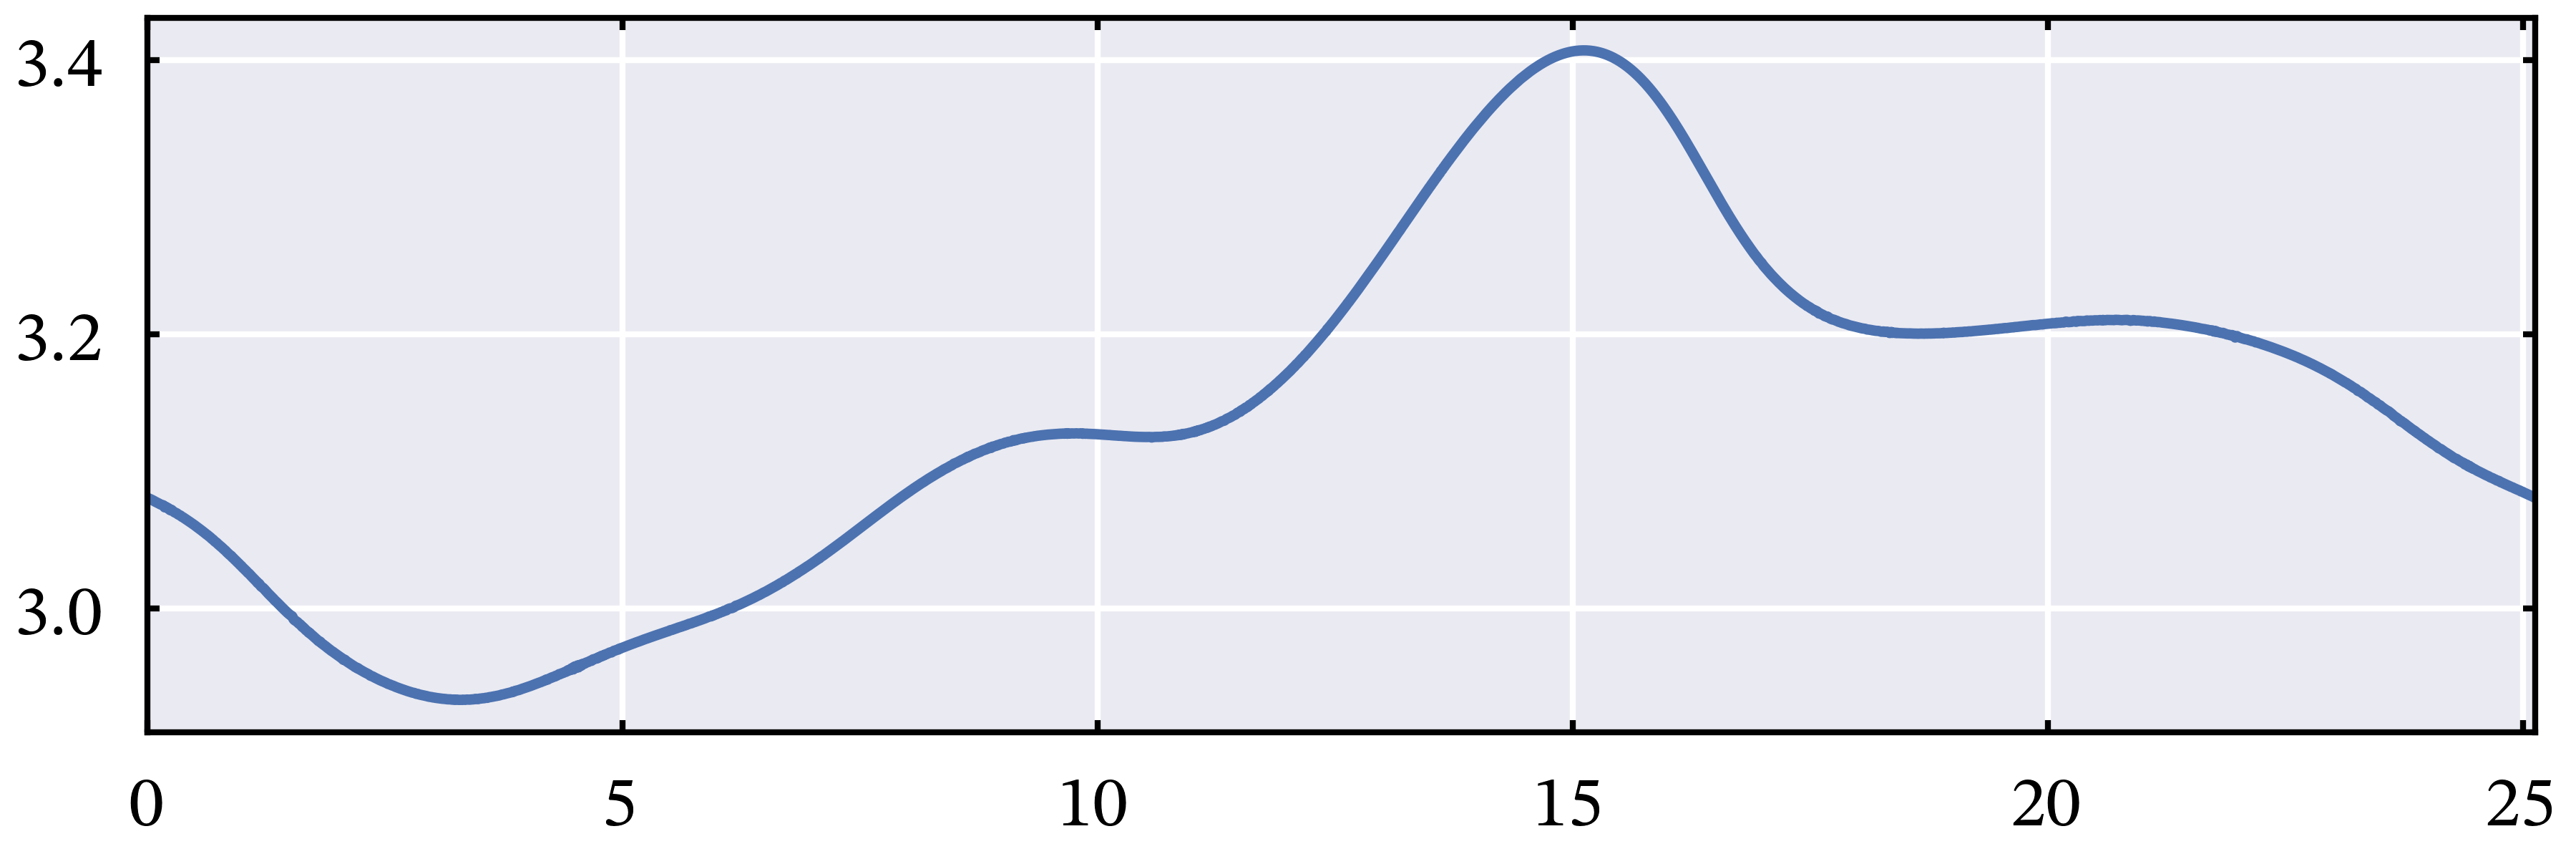

In [8]:
# Pick the buoyancy contour to use as the boundary
con = np.pi

# Calculate buoyancy contour height
for j in range(nx):
    z0[j] = np.interp(con, zz + TH[j,:], zz)

fig, ax = plt.subplots(figsize=(6.0,2.0))
ax.plot(xx, z0)
ax.set_xlim((0,8*np.pi))
plt.show()

In [9]:
# Shift contour to top of domain, so z2 is the upper boundary surface
z2 = z0 + 2*np.pi - con
# Record mean vertical deviation of isopycnal surface
z1_mean = np.mean(z2) - 2*np.pi

### Construct reference profile $Z_*(b)$

Define the buoyancy field as $b= \left( z + \theta - \texttt{con}\right) \mod 2\pi$

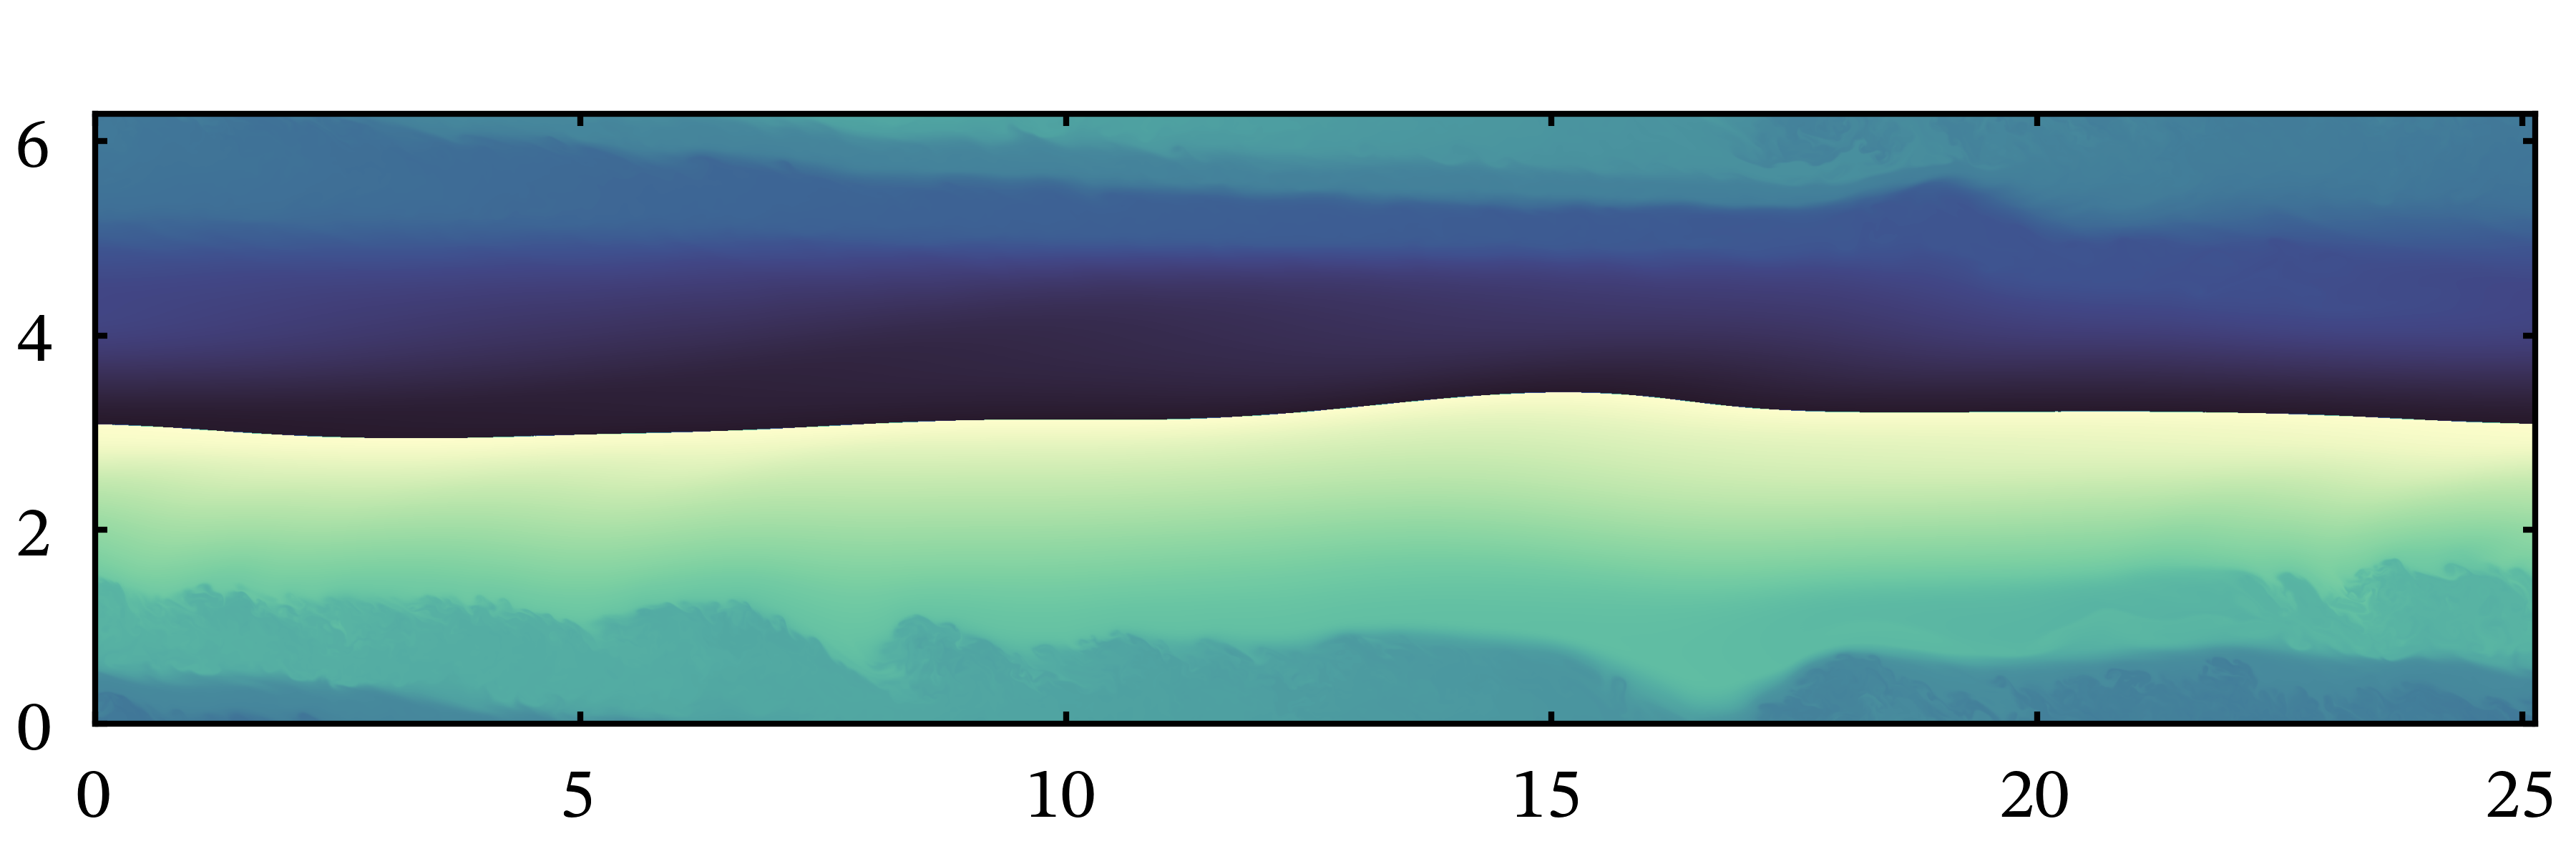

In [10]:
B = np.mod(zz + TH - con, 2*np.pi)

fig, ax = plt.subplots(figsize=(6.0,2.0))
ax.imshow(
    B.T, cmap='cmo.deep_r', vmin=0, vmax=2*np.pi, origin='lower',
    extent=[0, 8*np.pi, 0, 2*np.pi], aspect='equal'
)
ax.grid(False)
plt.show()

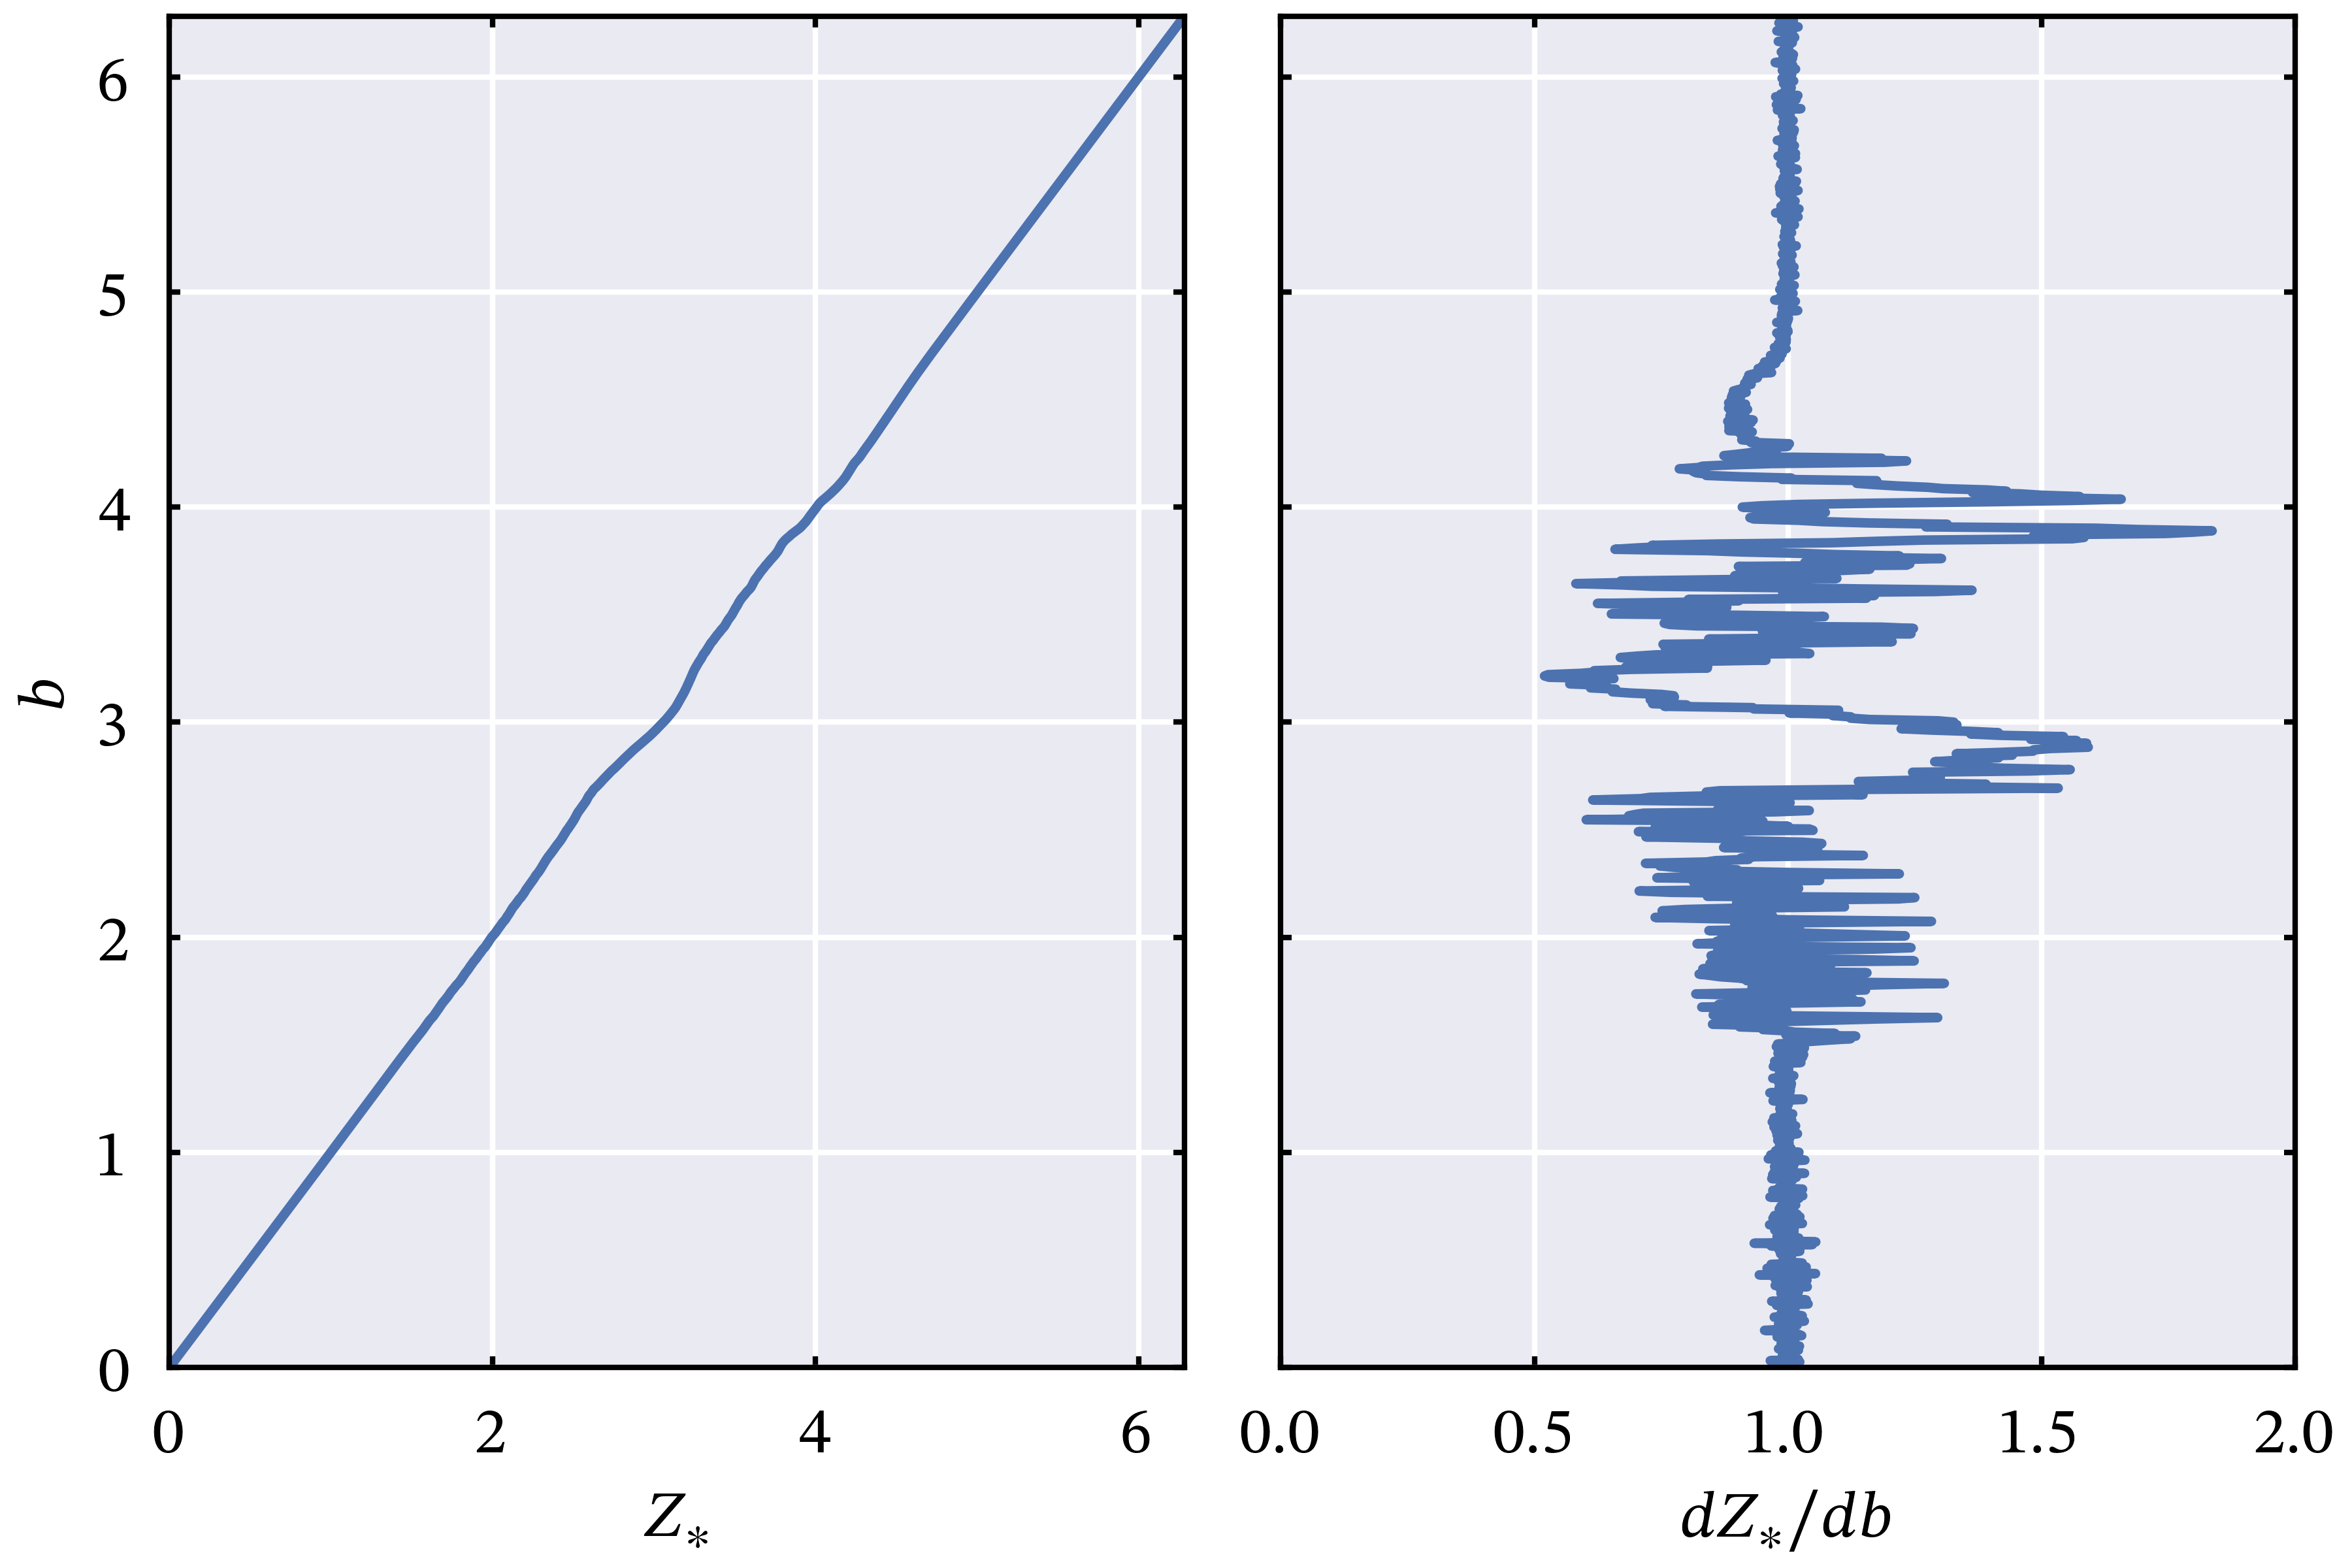

In [11]:
# Prescribe bin width as grid spacing
bw = 2*np.pi/nz

# Obtain histogram of the buoyancy field
H, s_edges = np.histogram(B.flatten(), bins=bw*np.arange(nz+1))
H = H/bw/np.sum(H)
z_r = np.zeros(nz)
for j in range(nz):
    z_r[j] = 2*np.pi*bw*np.sum(H[:j])
# Calculate derivative of reference profile
dzds = 1 + dds(z_r-zz)

fig, ax = plt.subplots(1,2, figsize=(6.0,4.0), sharey=True)
ax[0].plot(z_r, zz)
ax[0].set(xlim=(0,2*np.pi), ylim=(0,2*np.pi), ylabel="$b$", xlabel="$Z_*$")
ax[1].plot(dzds, zz)
ax[1].set(xlabel="$dZ_*/db$", xlim=(0,2), ylim=(0,2*np.pi))
plt.show()

### Compute volume-averaged potential energy quantities

In [12]:
# Extend vectors to interpolate accurately at high buoyancy values
s_int = np.concatenate((zz, [2*np.pi]))
z_int = np.concatenate((z_r, [2*np.pi]))
dz_int = np.concatenate((dzds, [dzds[0]]))

B = np.mod(zz + TH - con, 2*np.pi)
Z = np.mod(zz-con,2*np.pi) + 2*np.pi*(TH + zz < con)*(zz>=con) - 2*np.pi*(TH + zz >= con)*(zz<con)
Zstar = np.interp(B, s_int, z_int)
b_mean = np.mean(B)
EP = np.mean(-B*Z)
EB = np.mean(-B*Zstar)
EB = EB - b_mean*z1_mean + 0.5*(2*np.pi+z1_mean)**2
ES = np.mean(z2**2)/2
EA = EP + ES - EB

### Local APE calculation

In [13]:
# Use periodicity to extend reference profile
xnum = 128
svec = np.arange(nz + 2*xnum + 1)*bw - bw*xnum
Zrvec = np.concatenate((z_r[-xnum:]-2*np.pi, z_r, z_r[:xnum+1]+2*np.pi))
dZrvec = np.concatenate((dzds[-xnum:], dzds, dzds[:xnum+1]))

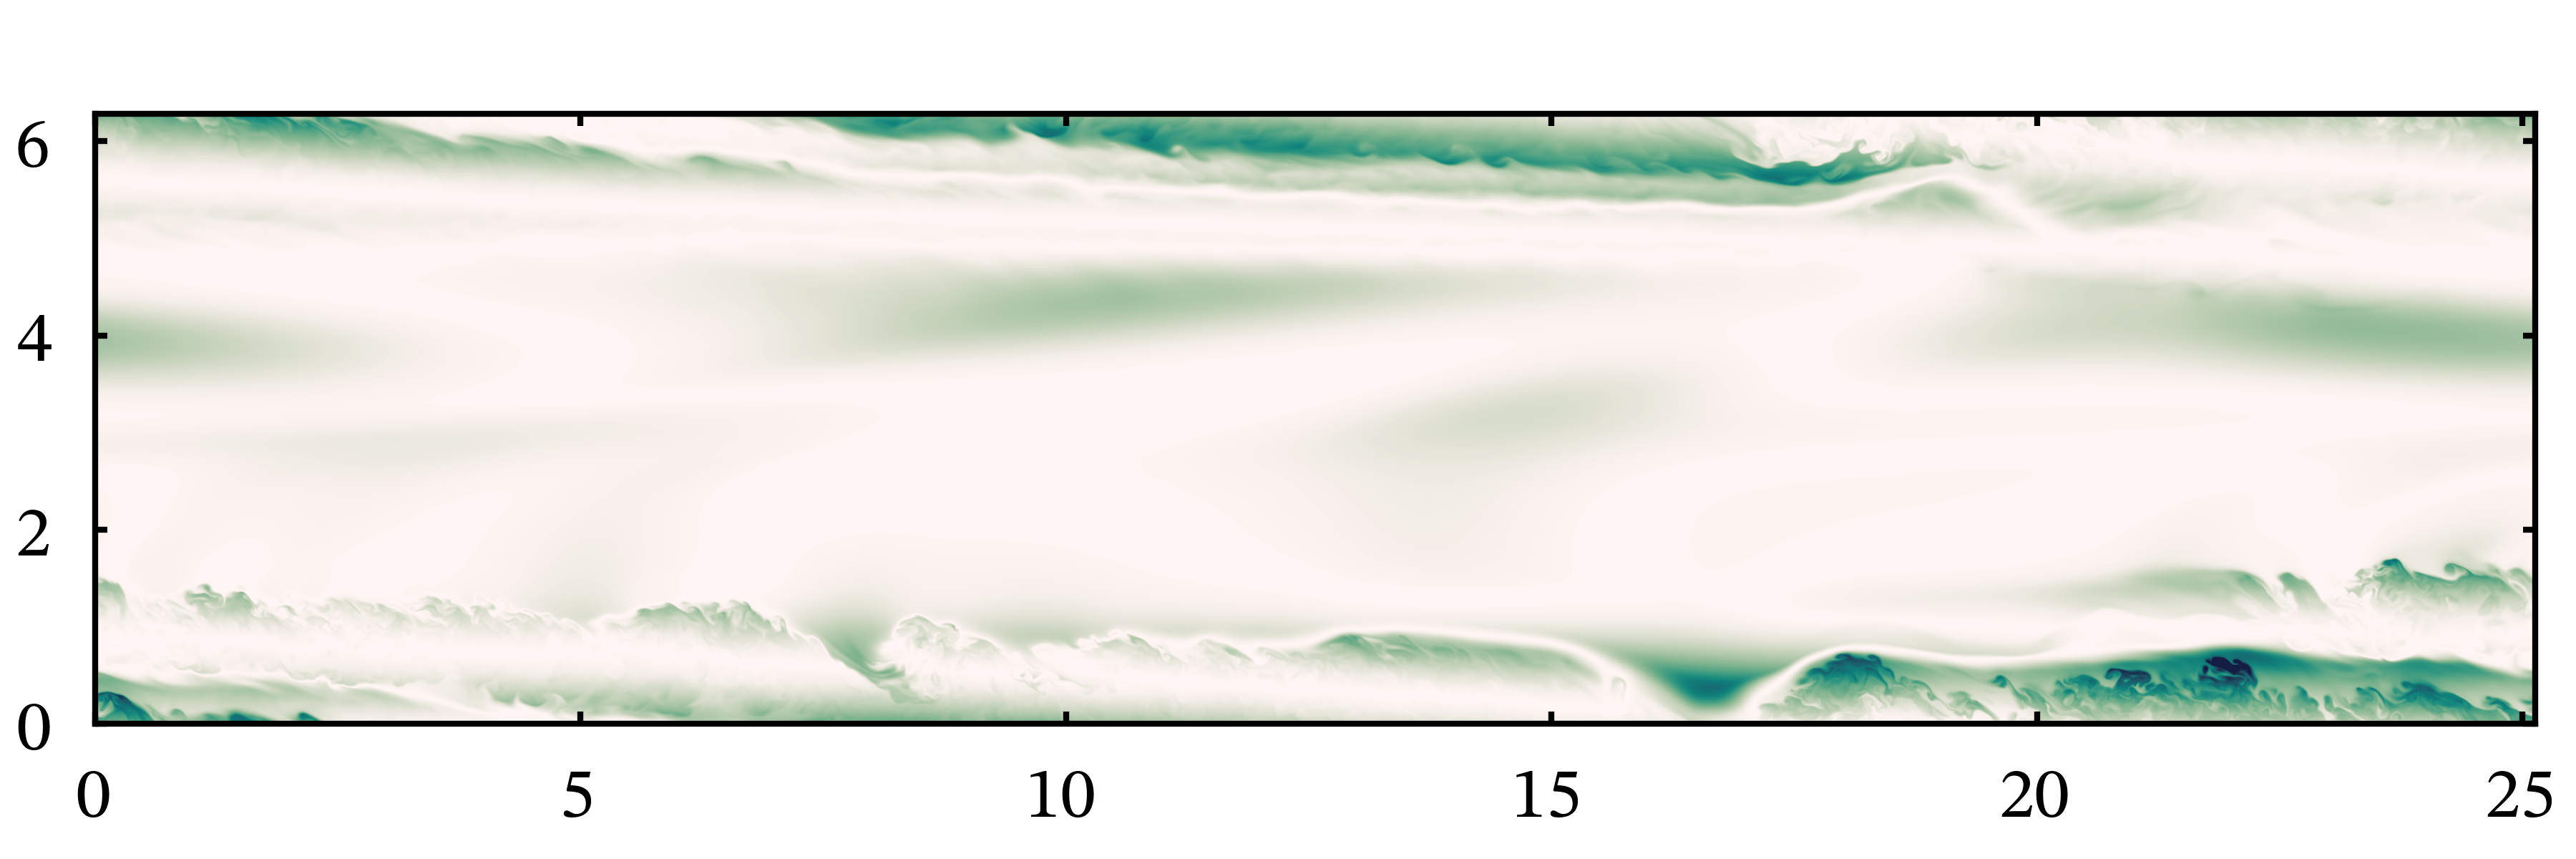

In [14]:
# Construct integral over Z*
iZrvec = np.zeros(svec.size)
for j in range(svec.size):
    iZrvec[j] = np.trapz(Zrvec[:j+1], x=svec[:j+1])

Bstar = np.interp(np.mod(zz-con,2*np.pi), z_int, s_int) \
    + 2*np.pi*(TH+zz<con)*(zz>=con) - 2*np.pi*(TH+zz>=con)*(zz<con)
iB = np.interp(B, svec, iZrvec)
iBstar = np.interp(Bstar, svec, iZrvec)
locAPE =  Z*(Bstar - B) + iB - iBstar
Ea = np.mean(locAPE)

Ea = Ea/nz
Eb = EP + ES - Ea

fig, ax = plt.subplots(figsize=(6.0,2.0))
ax.imshow(
    locAPE.T, cmap='cmo.tempo', origin='lower', vmin=0, vmax=0.4,
    extent=[0, 8*np.pi, 0, 2*np.pi], aspect='equal'
)
ax.grid(False)
plt.show()

### Compute diapycnal mixing and diffusivity

In [15]:
# Compute local buoyancy gradients
gradB2 = np.zeros(TH.shape)
gradB2 += 1 + ddz(TH)
for j in range(nx):
    # Compute db/dz on the isopycnal boundary for Fd term
    dBdy[j] = np.interp(z0[j], zz, gradB2[j,:])
gradB2 = gradB2**2
gradB2 += ddx(TH)**2
for j in range(nx):
    tmpFd[j] = np.interp(z0[j], zz, gradB2[j,:])

In [16]:
# Record diffusive flux at the isopycnal boundary
tmpFd = tmpFd/dBdy/Re
Fd = np.mean(tmpFd)

# Record mean mixing rate and diffusivity
dZdB = np.interp(B, s_int, dz_int)
M = np.mean(gradB2*dZdB)
Kd = np.mean(gradB2*dZdB**2)

M = M/Re - Dp
Kd = Kd/Re

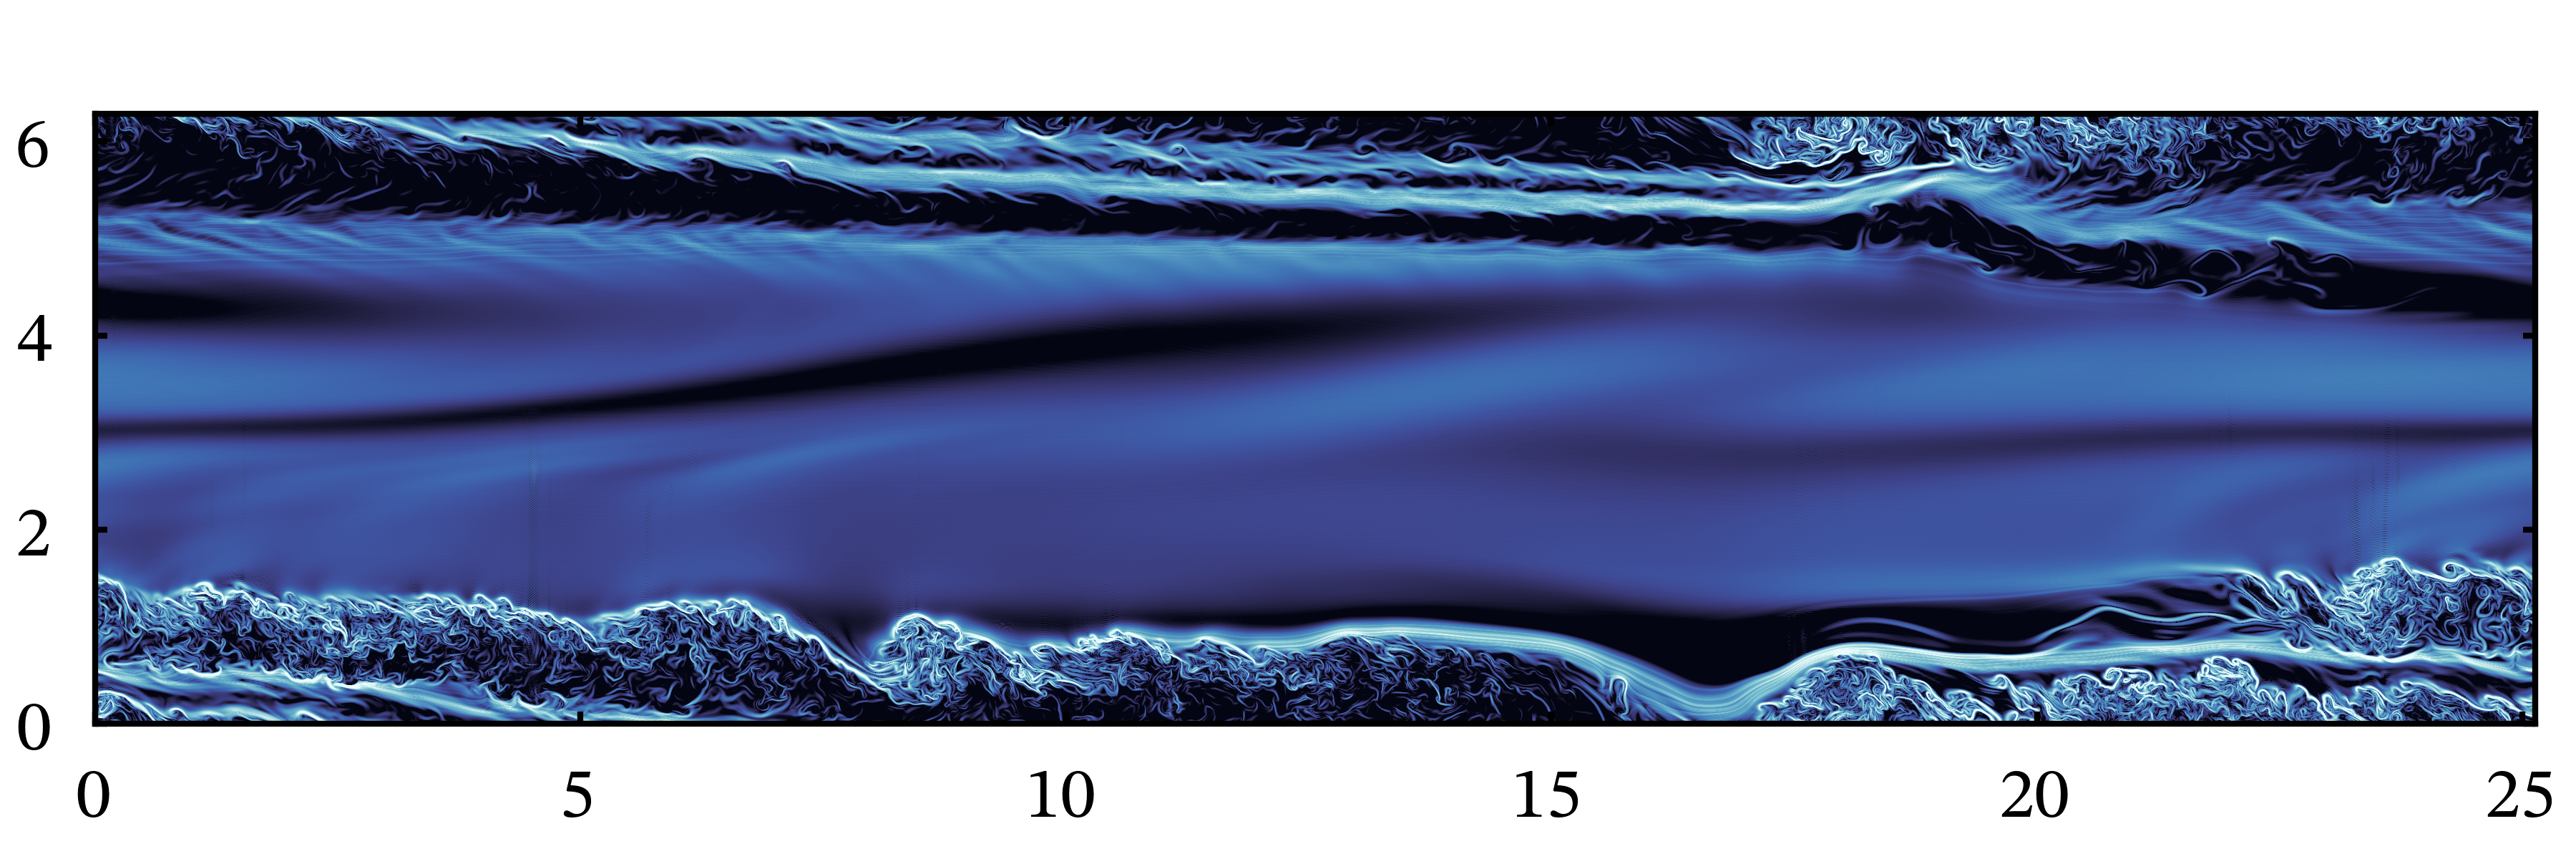

In [17]:
fig, ax = plt.subplots(figsize=(6.0,2.0))
im = ax.imshow(
    np.log10(gradB2*dZdB**2).T, cmap='cmo.ice', origin='lower', vmin=-1, vmax=2,
    extent=[0, 8*np.pi, 0, 2*np.pi], aspect='equal'
)
ax.grid(False)
plt.show()

In [18]:
# Overview of data saved
# P     "internal" potential energy
# S     surface potential energy
# B     background potential energy
# A     available potential energy
# E_B   average local BPE
# E_A   average local APE
# M     diapycnal mixing rate
# Dp    internal energy conversion rate
# Kd    diapycnal diffusivity
# b_mean    volume-averaged buoyancy
# z1_mean   mean deviation of boundary isopycnal
# z_r   background profile Z*(s)
# Fd    diffusive boundary flux